<a href="https://colab.research.google.com/github/AngusYeh/Machinelearning/blob/main/Email_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/emails.csv')

In [3]:
df.shape

(5172, 3002)

In [4]:
df1 = df[(df['the']<df['the'].quantile(0.999)) & (df['the']>df['the'].quantile(0.001))]

In [5]:
df1.shape

(3843, 3002)

In [6]:
X = df.drop(['Email No.','Prediction'],axis = 1)

In [7]:
y = df['Prediction']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


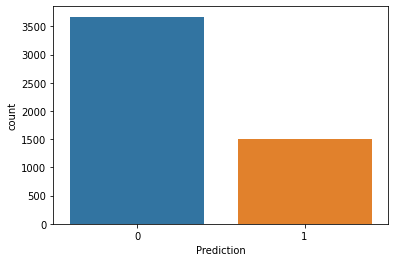

In [8]:
sns.countplot(y)
#plt.text()

## feature 若太多 本例有多達3000個，可以用主成分分析PCA篩選過多的因素

In [9]:
from sklearn.decomposition import PCA

In [10]:
# 只取10個做測試
pca = PCA(n_components=10)
X_new = pca.fit_transform(X)

In [11]:
X_new.shape

(5172, 10)

In [12]:
# 查看PCA後剩下的成分
a = pca.feature_names_in_
b = pca.explained_variance_ratio_
for i,j in zip(a,b):
  print('feature_name:',i,'ratio:',j)

feature_name: the ratio: 0.9280330632324068
feature_name: to ratio: 0.01342010299521109
feature_name: ect ratio: 0.010852404564160789
feature_name: and ratio: 0.006622037378798167
feature_name: for ratio: 0.004859405973813999
feature_name: of ratio: 0.003956526014229872
feature_name: a ratio: 0.002633254758384831
feature_name: you ratio: 0.002324279084921709
feature_name: hou ratio: 0.0020531233061720925
feature_name: in ratio: 0.0019360328827671342


#　將資料切割訓練與測試資料ｓｅｔ

In [13]:
from sklearn.model_selection import train_test_split,ShuffleSplit

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.2,random_state=42)

In [15]:
cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=42)
n = cv.split(X_new)

In [22]:
shuff = cross_val_score(LogisticRegression(max_iter=1000),X_new,y,cv=cv)
shuff

array([0.81352657, 0.79323671, 0.77584541, 0.79806763, 0.78067633])

# 建構模型

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier

In [26]:
# 建構模型種類
model ={
    "logistic":LogisticRegression(max_iter=1000),
    "Decision":DecisionTreeClassifier(),
    #"SVC":SVC(),
    "RFC":RandomForestClassifier(),
    "NB":GaussianNB()
}

#評估標準
scores =["accuracy","precision","recall"]

In [18]:
#檢測訓練品質
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
from sklearn.metrics import precision_score,recall_score,f1_score,plot_precision_recall_curve,precision_recall_curve,make_scorer
from sklearn.model_selection import cross_val_score,cross_val_predict#交叉驗證

lg = LogisticRegression()
DS = DecisionTreeClassifier()
NB = GaussianNB()
vote = VotingClassifier(estimators=[
    ('1',lg),('2',DS),('3',NB)],
    voting = 'soft'
)

vote.fit(X_train,y_train)

pre = vote.predict_proba(X_test)
pre

In [23]:
import prettytable as pt

In [30]:
# 交叉驗證 訓練平均分數表現
def cross_val_score_mean(est,score):
  tb1 = pt.PrettyTable()
  tb1.field_names=['model_name','accuracy_score','precision_score','recall_score'] 
  for model_name,model in est.items():
    mata_data = {}
    for s in score:
      cvs = cross_val_score(model,X_train,y_train,cv=3,scoring = s)
      mata_data[s]=cvs.mean()      
    tb1.add_row([model_name,mata_data['accuracy'],mata_data['precision'],mata_data['recall']])
  print(tb1)

In [28]:
cross_val_score_mean(model,scores)

+------------+--------------------+--------------------+---------------------+
| model_name |   accuracy_score   |  precision_score   |     recall_score    |
+------------+--------------------+--------------------+---------------------+
|  logistic  | 0.7846265409717187 | 0.765625705341978  | 0.37458592325157253 |
|  Decision  | 0.7855934251873338 | 0.6245666958788699 |  0.6220787169720806 |
|    RFC     | 0.8365965675610344 | 0.7756660027264762 |  0.6129783336021473 |
|     NB     | 0.7128353879622916 | 0.5206062589525409 | 0.17773352687931912 |
+------------+--------------------+--------------------+---------------------+


In [31]:
# prediction 與 y_test 資料各項分數比較
tb2 = pt.PrettyTable()
tb2.field_names = ['model_name','accuracy_score','precision_score','recall_score']

def get_accuracy_recall_predision_score(est,X,Y,x,y):
  for model_name,model_a in est.items():
    pred = model_a.fit(X,Y).predict(x)
    tb2.add_row([model_name,accuracy_score(y,pred),precision_score(y,pred),recall_score(y,pred)])
  print(tb2)
    #print(f"{model_name}: {accuracy_score(y,pred)}, {precision_score(y,pred)}, ")

In [ ]:
get_accuracy_recall_predision_score(model,X_train,y_train,X_test,y_test)
# 下表可以看出 Logistic 跟 隨機森林有較高acc的分數

+------------+--------------------+--------------------+---------------------+
| model_name |   accuracy_score   |  precision_score   |     recall_score    |
+------------+--------------------+--------------------+---------------------+
|  logistic  | 0.8153446033810143 | 0.7637795275590551 | 0.46411483253588515 |
|  Decision  | 0.776332899869961  | 0.5876777251184834 |  0.5933014354066986 |
|    RFC     | 0.8556566970091027 | 0.8181818181818182 |  0.6028708133971292 |
|     NB     | 0.7373211963589077 | 0.5507246376811594 | 0.18181818181818182 |
+------------+--------------------+--------------------+---------------------+


# 使用GRIDSearchCV 來測試超參數調整後的表現

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

In [34]:
def compare_precision_recall_(est,X,y,sample_weight=None):
  pred = est.predict(X)
  precision = precision_score(y,pred)
  recall = recall_score(y,pred)
  return min(precision,recall)


In [35]:
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={
        'class_weight':[{0:1,1:v} for v in np.linspace(1,15,20)]
        
    },
    scoring = {'precision':make_scorer(precision_score),'recall':make_scorer(recall_score),'compare':(compare_precision_recall_)},
    refit = 'compare',
    cv = 3
)

In [40]:
grid_logist = grid.fit(X_train,y_train)

In [41]:
results = pd.DataFrame(grid_logist.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_precision,split1_test_precision,split2_test_precision,mean_test_precision,...,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_compare,split1_test_compare,split2_test_compare,mean_test_compare,std_test_compare,rank_test_compare
0,0.043106,0.006862,0.004932,0.000014,"{0: 1, 1: 1.0}","{'class_weight': {0: 1, 1: 1.0}}",0.773196,0.755208,0.768473,0.765626,...,0.389027,0.374586,0.011246,20,0.373134,0.361596,0.389027,0.374586,0.011246,13
1,0.042367,0.001151,0.004933,0.000006,"{0: 1, 1: 1.736842105263158}","{'class_weight': {0: 1, 1: 1.736842105263158}}",0.662757,0.645833,0.673469,0.660686,...,0.576060,0.559799,0.014353,19,0.562189,0.541147,0.576060,0.559799,0.014353,1
2,0.039701,0.005561,0.005030,0.000053,"{0: 1, 1: 2.473684210526316}","{'class_weight': {0: 1, 1: 2.473684210526316}}",0.550459,0.548983,0.550285,0.549909,...,0.723192,0.736703,0.009825,18,0.550459,0.548983,0.550285,0.549909,0.000658,2
3,0.037810,0.004465,0.004981,0.000039,"{0: 1, 1: 3.2105263157894735}","{'class_weight': {0: 1, 1: 3.2105263157894735}}",0.474898,0.475207,0.489451,0.479852,...,0.867830,0.866275,0.004345,17,0.474898,0.475207,0.489451,0.479852,0.006789,3
4,0.042890,0.002381,0.004997,0.000022,"{0: 1, 1: 3.9473684210526314}","{'class_weight': {0: 1, 1: 3.9473684210526314}}",0.447044,0.436536,0.458281,0.447287,...,0.917706,0.912799,0.006939,16,0.447044,0.436536,0.458281,0.447287,0.008879,4
5,0.046631,0.006827,0.004986,0.000041,"{0: 1, 1: 4.684210526315789}","{'class_weight': {0: 1, 1: 4.684210526315789}}",0.424312,0.421875,0.431193,0.425793,...,0.937656,0.933566,0.009531,15,0.424312,0.421875,0.431193,0.425793,0.003945,5
6,0.039048,0.009986,0.005037,0.000027,"{0: 1, 1: 5.421052631578947}","{'class_weight': {0: 1, 1: 5.421052631578947}}",0.411572,0.408946,0.419142,0.413220,...,0.950125,0.948514,0.008161,14,0.411572,0.408946,0.419142,0.413220,0.004323,6
7,0.044243,0.004483,0.004985,0.000143,"{0: 1, 1: 6.157894736842105}","{'class_weight': {0: 1, 1: 6.157894736842105}}",0.402529,0.400831,0.410448,0.404602,...,0.960100,0.957647,0.005330,13,0.402529,0.400831,0.410448,0.404602,0.004191,7
8,0.044011,0.002454,0.004908,0.000015,"{0: 1, 1: 6.894736842105263}","{'class_weight': {0: 1, 1: 6.894736842105263}}",0.394063,0.394280,0.400415,0.396253,...,0.962594,0.960966,0.002301,12,0.394063,0.394280,0.400415,0.396253,0.002944,8
9,0.118725,0.008180,0.006563,0.001539,"{0: 1, 1: 7.63157894736842}","{'class_weight': {0: 1, 1: 7.63157894736842}}",0.389610,0.385913,0.394523,0.390015,...,0.970075,0.970100,0.000035,11,0.389610,0.385913,0.394523,0.390015,0.003527,9


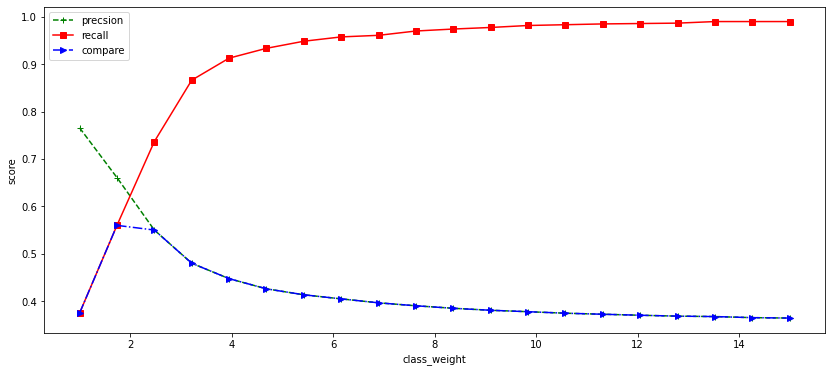

In [50]:
fig = plt.figure(figsize=(14,6))
x_scale=results['param_class_weight']
plt.plot([i[1] for i in x_scale],results['mean_test_precision'],'g--+',label='precsion')
plt.plot([i[1] for i in x_scale],results['mean_test_recall'],'r-s',label='recall')
plt.plot([i[1] for i in x_scale],results['mean_test_compare'],'b-.>',label='compare')
plt.xlabel('class_weight')
plt.ylabel('score')

plt.legend()
plt.show()

In [44]:
grid_decision_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        'class_weight':[{0:1,1:v} for v in np.linspace(1,20,30)],
        #'max_depth':[5,6,7,8,9,10,11,12],
    },
    cv = 5,
    scoring = {'precision':make_scorer(precision_score),'recall':make_scorer(recall_score),'compare':(compare_precision_recall_)},
    refit = 'compare',
)

In [45]:
grid_ds = grid_decision_tree.fit(X_train,y_train)

In [ ]:
grid_decision_tree.get_params()

In [48]:
results_2 = pd.DataFrame(grid_decision_tree.cv_results_)

In [47]:
grid_ds.best_params_

{'class_weight': {0: 1, 1: 1.0}}

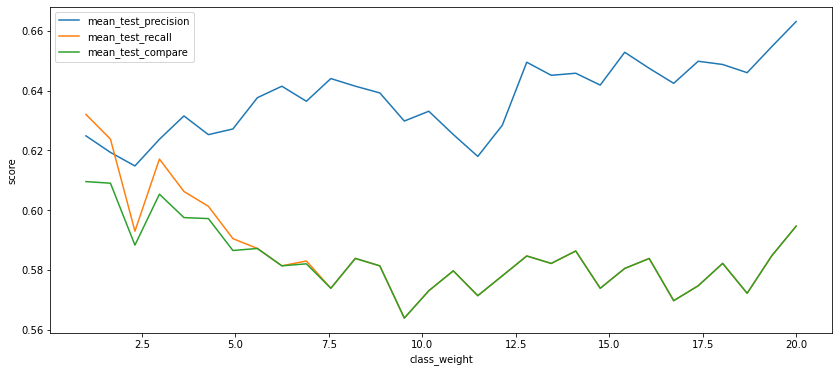

In [49]:
fig = plt.figure(figsize=(14,6))
for scoring in ['mean_test_precision','mean_test_recall','mean_test_compare']:
  plt.plot([_[1] for _ in results_2['param_class_weight']],results_2[scoring],label=scoring)
plt.xlabel('class_weight')
plt.ylabel('score')
plt.legend()
plt.show()

In [51]:
from sklearn.tree import plot_tree
DSt = DecisionTreeClassifier(class_weight={0:1,1:4},max_depth=8)
DSt.fit(X_train,y_train)
#DSt.predict(X_test)

DecisionTreeClassifier(class_weight={0: 1, 1: 4}, max_depth=8)

In [ ]:
DSt.get_n_leaves()

128

In [ ]:
fig = plt.figure(figsize=(14,9))
plot_tree(DSt)

# XGB

In [ ]:
xgb = XGBClassifier(n_estimators=100)

In [ ]:
xgb.fit(X_train,y_train)

XGBClassifier()

In [ ]:
pred = xgb.predict(X_test)

In [ ]:
print(accuracy_score(y_test,pred))

0.8374512353706112


# SGD

In [ ]:
sgd = SGDClassifier(random_state=100)
sgd.fit(X_train,y_train)

SGDClassifier(random_state=100)

In [ ]:
pred = sgd.predict(X_test)
print(accuracy_score(y_test,pred))
print(precision_score(y_test,pred))
print(recall_score(y_test,pred))

0.8057971014492754
0.8116883116883117
0.4208754208754209


In [ ]:
y_scores = cross_val_predict(sgd, X_train, y_train, cv=3,method='decision_function')

In [ ]:
y_scores

array([  1221.55750681, -15163.34128899,    694.10660409, ...,
        -3387.97458363,  -3476.13519723,  -5928.42865919])

In [ ]:
a,b,c=precision_recall_curve(y_train,y_scores)

In [ ]:
c.shape

(3677,)

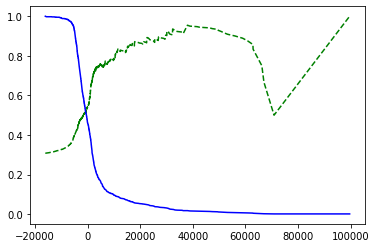

In [ ]:
plt.plot(c,a[:-1],'g--')
plt.plot(c,b[:-1],'b-')